# Combining Traditional NLP with GenAI for Twitter Customer Support Analysis on Databricks

### Loading the Dataset from DBFS

In this step, we first manually uploaded the dataset to DBFS. Then, we use Spark to load the dataset (in Delta format) into a DataFrame. The cell below performs the following actions:
1. Loads the dataset from the specified DBFS location.
2. Displays the first few rows to give an overview of the data.
3. Prints the schema to check the data structure.
4. Prints the total number of tweets in the dataset.


In [0]:
# Load the dataset
twitter_df = spark.read \
    .option("maxFiles", 1) \
    .format("delta") \
    .load("/user/hive/warehouse/twcs")

# Show the first few rows
display(twitter_df)

# Check the schema
twitter_df.printSchema()

# Get basic statistics
print(f"Total number of tweets: {twitter_df.count()}")

tweet_id author_id inbound created_at text response_tweet_id in_response_to_tweet_id 2326682 673845 true Mon Nov 13 06:55:34 +0000 2017 @AirAsiaSupport The batteries can be removed 2326681,2326683 2326662 2326662 AirAsiaSupport false Mon Nov 13 06:54:51 +0000 2017 @673845 If the batteries can be removed, you may proceed to bring it accordingly. However should the batteries are non removable >> 2326682 2326661 2326684 Ask_WellsFargo false Fri Oct 20 00:23:53 +0000 2017 @673847 Hi there. Let me know if I can look into something for you. I'll do my best to help. ^MH null 2326685 2326685 673847 true Thu Oct 19 23:41:37 +0000 2017 So apparently they don’t do the “woo” thing anymore at Wells Fargo and I found out the hard way. 2326684 null 2326683 AirAsiaSupport false Mon Nov 13 12:44:28 +0000 2017 @673845 If the batteries can be removed , yes you may proceed to travel with said item. Please comply with the allowed dimension >> 2326686 2326682 2326686 581618 true Mon Nov 13 12:55:21 +0000 2017 @AirAsiaSupport @673845 They changed my flight twice on schedule. Always to arrive later. Now that I ask you to pass me to the previous one, they refuse. @115802 are you going to fix my problem when you are the cause? 2326687 2326683 2326687 AirAsiaSupport false Tue Nov 14 01:46:58 +0000 2017 @581618 we have replied to you via DM.Thanks null 2326686 2326688 AirAsiaSupport false Mon Nov 13 12:20:15 +0000 2017 @673848 Hi There,for value pack meal is fixed and cant be choose,kindly refer here https://t.co/Z16kjMiPjx Thanks- Anwar null 2326689 2326689 673848 true Mon Nov 13 07:02:44 +0000 2017 @AirAsiaSupport I have Value Pack for 5 people. Can I choose food for 5 different people or I have to choose 1 Menu for 5 people? 2326688 null 2326690 AirAsiaSupport false Mon Nov 13 12:01:32 +0000 2017 @492081 >> can only be prebooked within 24 hours before the flight time. Sorry for the inconvenience caused - Nod null 2326691 2326691 492081 true Mon Nov 13 11:36:08 +0000 2017 @AirAsiaSupport Hi Yana, pls change it for all passenger. Tks. 2326690,2326692 2326693 2326693 AirAsiaSupport false Mon Nov 13 08:15:37 +0000 2017 @492081 Dear Saurabh, please provide the passengers name for meal preference change to Veggie meal -Yana 2326691 2326694 2326694 492081 true Mon Nov 13 04:52:59 +0000 2017 @AirAsiaSupport Mariya,I have already DM Air Asia my booking number. Request if you can help with change in meal preference. Tks. 2326693 2326695 2326695 AirAsiaSupport false Mon Nov 13 02:25:20 +0000 2017 @492081 Hi Saurabh , Appreciate you dm us your booking number please . Thanks- Mariya 2326694 2326696 2326696 492081 true Mon Nov 13 00:02:18 +0000 2017 @AirAsiaSupport We have already paid for Value add just need a change from NVML to VGML.Tks. 2326695 2326697 2326697 AirAsiaSupport false Sun Nov 12 15:21:23 +0000 2017 @492081 >> need to prebook the meals accordingly for your flight. Sorry for the inconvenience caused - Nod 2326696 2326698 2326698 492081 true Sun Nov 12 14:00:38 +0000 2017 @AirAsiaSupport Dear Team, pls respond. Tks. 2326697 1603434 1603434 492081 true Sun Nov 12 09:02:15 +0000 2017 @AirAsiaSupport Team,I have dropped DM for change in meal preference for AK1717 14Nov17 LGK-SIN.Pls assist.Tks. 2326698 1603433 2326692 AirAsiaSupport false Mon Nov 13 12:01:09 +0000 2017 @492081 We're sorry as the Value Pack meals cannot be changed once confirmed as it will be preselected. Please be advise that meal >> 2326699 2326691 2326699 492081 true Mon Nov 13 14:21:45 +0000 2017 @AirAsiaSupport I have been following with your team outside 24hrs. Leave it, if it's beyond scope. Regret. 2326700 2326692 2326700 AirAsiaSupport false Tue Nov 14 02:56:44 +0000 2017 @492081 Sorry Saurabh, :( Have a nice trip. -Amie null 2326699 2326701 AirAsiaSupport false Mon Nov 13 11:53:37 +0000 2017 @673849 Hi There :) Correction done. Please check your mailbox for the revised itinerary. Thank you- Anwar null 2326702 2326702 673849 true Mon Nov 13 06:45:19 +0000 2017 @AirAsiaSupport Hi!

root
 |-- tweet_id: long (nullable = true)
 |-- author_id: string (nullable = true)
 |-- inbound: boolean (nullable = true)
 |-- created_at: string (nullable = true)
 |-- text: string (nullable = true)
 |-- response_tweet_id: string (nullable = true)
 |-- in_response_to_tweet_id: long (nullable = true)

Total number of tweets: 2966469


###  Data Quality and Author Distribution Analysis

This cell performs several exploratory data analysis tasks:
1. **Missing Values Check:**  
   It uses Spark SQL functions (e.g., `isnull`, `when`, `count`) to count the number of missing or empty values in each column of the dataset, then displays these counts.
2. **Inbound Tweets Sample:**  
   It filters the dataset to extract tweets that are inbound (i.e., messages sent to companies), displays a sample of 10 inbound tweets, and prints the total count of inbound tweets.
3. **Tweets by Author:**  
   It groups the tweets by `author_id`, counts the number of tweets per author, orders the authors by tweet count in descending order, and displays the top 20 authors.


In [0]:
# Let's check for missing values
from pyspark.sql.functions import col, count, when, isnan, isnull

# Count missing values for each column
missing_counts = twitter_df.select([
    count(
        when(
            isnull(col(c)) | 
            (col(c) == "") if twitter_df.schema[c].dataType != "BooleanType" else isnull(col(c)), 
            c
        )
    ).alias(c) 
    for c in twitter_df.columns
])
display(missing_counts)

# Get a sample of inbound tweets (messages sent to companies)
inbound_tweets = twitter_df.filter(col("inbound") == True)
display(inbound_tweets.limit(10))
print(f"Number of inbound tweets: {inbound_tweets.count()}")

# Let's examine the distribution of tweets by author
from pyspark.sql.functions import count, desc
author_counts = twitter_df.groupBy("author_id").count().orderBy(desc("count"))
display(author_counts.limit(20))

tweet_id author_id inbound created_at text response_tweet_id in_response_to_tweet_id 154482 68073 154695 146363 153179 1273515 1013196

tweet_id author_id inbound created_at text response_tweet_id in_response_to_tweet_id 789830 291022 true Thu Oct 12 11:50:59 +0000 2017 @115911 I’m under a contract. Can you help me get out from under them? 789829 null 776388 308357 true Thu Oct 12 11:56:36 +0000 2017 @SouthwestAir Do you happen to know what islands you are planning on flying into? Maui perhaps? 789831 776192 789833 308358 true Thu Oct 12 11:47:59 +0000 2017 @SouthwestAir thanks for another safe flight from RDU to BNA. As always it was a pleasure flying SWA. Stoked about #SWAHawaii 789832 null 789835 308360 true Thu Oct 12 12:58:15 +0000 2017 @SouthwestAir @308359 Now we just need to earn the companion pass again! Love Southwest! Aloha! 789837 789834 789836 308359 true Thu Oct 12 11:47:41 +0000 2017 Pretty pumped to wake up to news that @SouthwestAir will start service to Hawaii in 2018! Been wishing for them to fly there for years! 789834 null 789839 308361 true Thu Oct 12 11:52:18 +0000 2017 @SouthwestAir Thanks! null 789838 789840 308361 true Thu Oct 12 11:44:42 +0000 2017 @SouthwestAir am I allowed to use a flight voucher towards my purchase if I book a flight via your sale that ends tonight? 789838 null 789842 159315 true Thu Oct 12 11:40:12 +0000 2017 @SouthwestAir ANNOUNCED SERVICE TO HAWAII!!! Better than Christmas morning!! Looks like I'll be needing some time off! #offtohawaiiigo 789841 null 789844 120282 true Thu Oct 12 11:41:19 +0000 2017 @SouthwestAir prices ALWAYS goes up the next day EVERY TIME they have a promotion! 789843 null 789846 308362 true Thu Oct 12 11:33:28 +0000 2017 @Ask_Spectrum Is there a known issue with authenticating Spectrum through TV channel apps? Getting an ELI-9000 error message on every app. 789845 null

Number of inbound tweets: 1537843


author_id count AmazonHelp 169840 AppleSupport 106860 null 68073 Uber_Support 56270 SpotifyCares 43265 Delta 42253 Tesco 38573 AmericanAir 36764 TMobileHelp 34317 comcastcares 33031 British_Airways 29361 SouthwestAir 28977 VirginTrains 27817 Ask_Spectrum 25860 XboxSupport 24557 sprintcare 22381 hulu_support 21872 sainsburys 19466 GWRHelp 19364 AskPlayStation 19098

### Text Preprocessing and Feature Extraction for Inbound Tweets

In this cell, we focus on inbound tweets by filtering for tweets where the "inbound" flag is True. Then, we clean the tweet text by converting it to lowercase, removing URLs, user mentions, and special characters, and filtering out very short texts. Next, we tokenize the cleaned text, remove stop words, and create a document-term matrix using CountVectorizer. Finally, we apply IDF to generate TF-IDF vectors, save the vocabulary for later use, display a sample of the processed data, and cache the DataFrame for faster downstream processing.


In [0]:
%python
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql.functions import udf, regexp_replace, lower, col, length
from pyspark.sql.types import StringType, ArrayType

# We'll focus on inbound tweets for our analysis
analysis_df = twitter_df.filter(col("inbound") == True)

# Clean the text
# 1. Convert to lowercase
# 2. Remove URLs
# 3. Remove user mentions (@username)
# 4. Remove special characters
clean_text = (analysis_df
              .withColumn("text_clean", lower(col("text")))
              .withColumn("text_clean", regexp_replace(col("text_clean"), "http\\S+", ""))
              .withColumn("text_clean", regexp_replace(col("text_clean"), "@\\w+", ""))
              .withColumn("text_clean", regexp_replace(col("text_clean"), "[^a-zA-Z0-9\\s]", " "))
              .withColumn("text_clean", regexp_replace(col("text_clean"), "\\s+", " "))
              .filter(col("text_clean").isNotNull())
              .filter(length(col("text_clean")) > 10)  # Filter out very short texts
             )

# Tokenize the text
tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
tokenized_df = tokenizer.transform(clean_text)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(tokenized_df)

# Apply CountVectorizer to create document-term matrix
# This will create a vocabulary and convert documents to vectors
cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features", 
                    minDF=5.0, vocabSize=10000)
cv_model = cv.fit(filtered_df)
vectorized_df = cv_model.transform(filtered_df)

# Apply IDF to get TF-IDF vectors
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(vectorized_df)
tfidf_df = idf_model.transform(vectorized_df)

# Save the vocabulary for later use
vocab = cv_model.vocabulary
print(f"Vocabulary size: {len(vocab)}")
vocab_df = spark.createDataFrame([(i, word) for i, word in enumerate(vocab)], ["index", "word"])
vocab_df.write.mode("overwrite").format("delta").save("/tmp/twitter_lda_vocab")

# Show sample of processed data
display(tfidf_df.select("tweet_id", "text", "text_clean", "filtered_words", "features").limit(5))

# Cache the data for faster processing
tfidf_df.cache()

Vocabulary size: 10000


tweet_id text text_clean filtered_words features 789830 @115911 I’m under a contract. Can you help me get out from under them? i m under a contract can you help me get out from under them List(, m, contract, help, get) Map(vectorType -> sparse, length -> 10000, indices -> List(0, 1, 2, 4, 881), values -> List(0.2252789466349455, 2.5895513235873375, 2.7117492859410377, 2.9296277384696303, 6.298034880694118)) 776388 @SouthwestAir Do you happen to know what islands you are planning on flying into? Maui perhaps? do you happen to know what islands you are planning on flying into maui perhaps List(, happen, know, islands, planning, flying, maui, perhaps) Map(vectorType -> sparse, length -> 10000, indices -> List(0, 26, 366, 504, 1761, 1801, 7788, 8143), values -> List(0.2252789466349455, 3.604741192324777, 5.319739769542566, 5.635536334872618, 7.07197495650967, 7.109246351306901, 9.407620911764603, 9.450545956481637)) 789833 @SouthwestAir thanks for another safe flight from RDU to BNA. As always it was a pleasure flying SWA. Stoked about #SWAHawaii thanks for another safe flight from rdu to bna as always it was a pleasure flying swa stoked about swahawaii List(, thanks, another, safe, flight, rdu, bna, always, pleasure, flying, swa, stoked, swahawaii) Map(vectorType -> sparse, length -> 10000, indices -> List(0, 5, 18, 101, 165, 366, 906, 2852, 3573, 4401, 4901, 9497), values -> List(0.2252789466349455, 2.9242823018750768, 3.44564143012099, 4.294014508992965, 4.642220126796749, 5.319739769542566, 6.301415165602942, 7.828902138368033, 8.106811209780542, 8.473011599366764, 8.661291465744348, 9.720836286221548)) 789835 @SouthwestAir @308359 Now we just need to earn the companion pass again! Love Southwest! Aloha! now we just need to earn the companion pass again love southwest aloha List(, need, earn, companion, pass, love, southwest, aloha) Map(vectorType -> sparse, length -> 10000, indices -> List(0, 16, 126, 452, 1381, 2642, 3256, 8501), values -> List(0.2252789466349455, 3.3397790606218853, 4.479880193844819, 5.538873889818279, 6.773377069180892, 7.7221561011861715, 7.998480281793543, 9.53278405471861)) 789836 Pretty pumped to wake up to news that @SouthwestAir will start service to Hawaii in 2018! Been wishing for them to fly there for years! pretty pumped to wake up to news that will start service to hawaii in 2018 been wishing for them to fly there for years List(pretty, pumped, wake, news, start, service, hawaii, 2018, wishing, fly, years) Map(vectorType -> sparse, length -> 10000, indices -> List(3, 247, 305, 372, 481, 844, 1243, 2334, 2463, 6461), values -> List(2.9000171519493425, 4.978005314266923, 5.158285686465519, 5.349063189282937, 5.57315071917358, 6.229567081416658, 6.660026843523426, 7.505889726085917, 7.574703370043041, 9.039249928062679))

DataFrame[tweet_id: bigint, author_id: string, inbound: boolean, created_at: string, text: string, response_tweet_id: string, in_response_to_tweet_id: bigint, text_clean: string, words: array<string>, filtered_words: array<string>, raw_features: vector, features: vector]

### Data Sampling, LDA Model Tuning, and Topic Extraction

In this cell, we perform several key tasks:

1. **Dataset Sampling:**
   - We sample 10,000 tweets from the preprocessed TF-IDF DataFrame and cache the sampled data.
   - We print both the original and sampled dataset sizes to verify the sampling process.

2. **LDA Model Tuning:**
   - We import and use PySpark’s LDA to build topic models.
   - A function `run_lda` is defined to train an LDA model for a given number of topics and maximum iterations.
   - For different topic counts (e.g., 10, 15, 20, 25, 30), we record the log likelihood and log perplexity to evaluate model performance.

3. **Visualization and Optimal Topic Selection:**
   - The tuning results are converted to a Pandas DataFrame.
   - We plot log likelihood and perplexity against the number of topics to help determine the optimal number of topics.
   - Based on these plots, an optimal number of topics (default set to 20) is selected.

4. **Final Model Training and Topic Extraction:**
   - Using the optimal number of topics, we train the final LDA model.
   - We extract topics, mapping term indices to words (using the saved vocabulary) along with their weights.
   - The topics, with their top terms and weights, are aggregated and displayed in a readable format.
   - Finally, the trained LDA model is saved for future use.


Original dataset size: 1449521
Sampled dataset size: 10015
Number of Topics: 10
Log Likelihood: -4176801.981921727
Log Perplexity: 8.26046020778797
Number of Topics: 15
Log Likelihood: -4265110.480544159
Log Perplexity: 8.435107902851664
Number of Topics: 20
Log Likelihood: -4374890.37538146
Log Perplexity: 8.652219572699476
Number of Topics: 25
Log Likelihood: -4493097.4659834355
Log Perplexity: 8.88599770544848
Number of Topics: 30
Log Likelihood: -4631920.135848723
Log Perplexity: 9.160547264016131


<module 'matplotlib.pyplot' from '/databricks/python/lib/python3.11/site-packages/matplotlib/pyplot.py'>

Number of Topics: 20
Log Likelihood: -4374890.3753814595
Log Perplexity: 8.652219572699474


topic top_terms 0 List(y: 0.0096, de: 0.0086, la: 0.0072, o: 0.0066, que: 0.0063, cant: 0.0053, un: 0.0053, amount: 0.0046, n: 0.0044, currently: 0.0040) 1 List(months: 0.0083, start: 0.0062, happening: 0.0056, travel: 0.0052, gave: 0.0050, purchase: 0.0046, point: 0.0043, look: 0.0042, bullshit: 0.0041, resolved: 0.0036) 2 List(dm: 0.0102, yes: 0.0078, thanks: 0.0064, make: 0.0060, hey: 0.0058, online: 0.0051, m: 0.0048, lot: 0.0048, ride: 0.0044, due: 0.0043) 3 List(fixed: 0.0075, right: 0.0067, tonight: 0.0055, plan: 0.0052, trip: 0.0049, means: 0.0045, seat: 0.0045, stuck: 0.0045, w: 0.0044, arrive: 0.0041) 4 List(playing: 0.0063, thing: 0.0061, idea: 0.0060, lol: 0.0047, 1st: 0.0045, new: 0.0043, using: 0.0042, fraud: 0.0040, black: 0.0039, place: 0.0038) 5 List(still: 0.0087, account: 0.0077, back: 0.0075, thank: 0.0071, help: 0.0069, m: 0.0068, order: 0.0066, ve: 0.0063, day: 0.0062, never: 0.0060) 6 List(hasn: 0.0056, told: 0.0056, called: 0.0052, complaint: 0.0052, change: 0.0051, staff: 0.0048, carrier: 0.0047, line: 0.0042, issue: 0.0039, sprint: 0.0039) 7 List(spotify: 0.0086, working: 0.0069, 11: 0.0068, ios: 0.0059, 0: 0.0058, free: 0.0053, return: 0.0050, reason: 0.0047, package: 0.0046, music: 0.0042) 8 List(news: 0.0053, error: 0.0050, ask: 0.0048, keep: 0.0046, done: 0.0042, info: 0.0039, current: 0.0039, stop: 0.0037, ever: 0.0036, offer: 0.0036) 9 List(different: 0.0068, afternoon: 0.0052, good: 0.0048, ordered: 0.0045, let: 0.0043, try: 0.0042, know: 0.0038, asap: 0.0036, halloween: 0.0035, confirm: 0.0030) 10 List(card: 0.0080, live: 0.0065, check: 0.0052, think: 0.0048, talk: 0.0047, least: 0.0045, going: 0.0044, oh: 0.0044, business: 0.0043, re: 0.0043) 11 List(really: 0.0091, best: 0.0061, regarding: 0.0051, log: 0.0043, mark: 0.0040, wtf: 0.0038, letter: 0.0034, details: 0.0034, quite: 0.0034, horrible: 0.0032) 12 List(customers: 0.0057, charge: 0.0055, fix: 0.0054, heard: 0.0053, dont: 0.0046, might: 0.0043, voicemail: 0.0041, think: 0.0040, sales: 0.0038, list: 0.0037) 13 List(delays: 0.0046, stream: 0.0045, flight: 0.0044, como: 0.0042, together: 0.0042, flights: 0.0039, x: 0.0038, red: 0.0035, move: 0.0035, kindle: 0.0034) 14 List(people: 0.0071, play: 0.0062, taken: 0.0057, internet: 0.0054, around: 0.0053, address: 0.0052, add: 0.0043, email: 0.0039, plane: 0.0037, drivers: 0.0036) 15 List(old: 0.0083, game: 0.0077, life: 0.0054, sucks: 0.0053, many: 0.0052, first: 0.0052, made: 0.0046, possible: 0.0046, soon: 0.0046, text: 0.0046) 16 List(say: 0.0060, delayed: 0.0055, sure: 0.0049, flight: 0.0048, actually: 0.0039, pretty: 0.0039, gone: 0.0038, price: 0.0038, 6: 0.0037, please: 0.0036) 17 List(2: 0.0078, service: 0.0076, customer: 0.0069, always: 0.0069, use: 0.0053, buy: 0.0051, something: 0.0048, code: 0.0047, need: 0.0044, phone: 0.0043) 18 List(iphone: 0.0070, minutes: 0.0069, nice: 0.0066, sent: 0.0063, 20: 0.0060, hard: 0.0052, 7: 0.0050, apple: 0.0048, service: 0.0045, hello: 0.0045) 19 List(train: 0.0125, watch: 0.0107, work: 0.0076, wifi: 0.0059, fine: 0.0052, update: 0.0046, lovely: 0.0046, website: 0.0044, agent: 0.0039, hope: 0.0038)

    topic                                           keywords
0       0  [y, de, la, o, que, cant, un, amount, n, curre...
1       1  [months, start, happening, travel, gave, purch...
2       2  [dm, yes, thanks, make, hey, online, m, lot, r...
3       3  [fixed, right, tonight, plan, trip, means, sea...
4       4  [playing, thing, idea, lol, 1st, new, using, f...
5       5  [still, account, back, thank, help, m, order, ...
6       6  [hasn, told, called, complaint, change, staff,...
7       7  [spotify, working, 11, ios, 0, free, return, r...
8       8  [news, error, ask, keep, done, info, current, ...
9       9  [different, afternoon, good, ordered, let, try...
10     10  [card, live, check, think, talk, least, going,...
11     11  [really, best, regarding, log, mark, wtf, lett...
12     12  [customers, charge, fix, heard, dont, might, v...
13     13  [delays, stream, flight, como, together, fligh...
14     14  [people, play, taken, internet, around, addres...
15     15  [old, game, l

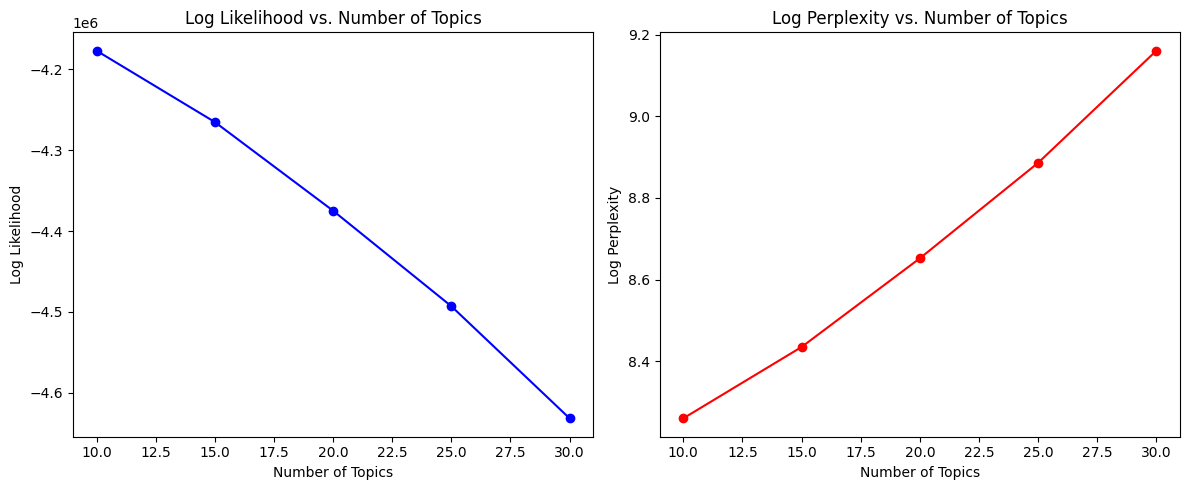

In [0]:
# Sample a larger dataset (10,000 tweets)
sampled_tfidf_df = tfidf_df.sample(withReplacement=False, fraction=10000/tfidf_df.count(), seed=42)
sampled_tfidf_df.cache()

print(f"Original dataset size: {tfidf_df.count()}")
print(f"Sampled dataset size: {sampled_tfidf_df.count()}")

from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf, col, explode, arrays_zip, collect_list, concat_ws, format_number
from pyspark.sql.types import ArrayType, StringType, DoubleType, StructType, StructField
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a function to try different numbers of topics
def run_lda(df, num_topics, max_iterations=10):
    lda = LDA(k=num_topics, maxIter=max_iterations, featuresCol="features")
    model = lda.fit(df)
    
    # Get log likelihood and perplexity
    ll = model.logLikelihood(df)
    lp = model.logPerplexity(df)
    
    print(f"Number of Topics: {num_topics}")
    print(f"Log Likelihood: {ll}")
    print(f"Log Perplexity: {lp}")
    
    return model, ll, lp

# Try more numbers of topics
num_topics_list = [10, 15, 20, 25, 30]
results = []

for num_topics in num_topics_list:
    model, ll, lp = run_lda(sampled_tfidf_df, num_topics)
    results.append({"num_topics": num_topics, "log_likelihood": ll, "log_perplexity": lp})
    
# Convert to pandas for visualization
results_df = pd.DataFrame(results)

# Plot the results to find the optimal number of topics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df["num_topics"], results_df["log_likelihood"], "bo-")
plt.xlabel("Number of Topics")
plt.ylabel("Log Likelihood")
plt.title("Log Likelihood vs. Number of Topics")

plt.subplot(1, 2, 2)
plt.plot(results_df["num_topics"], results_df["log_perplexity"], "ro-")
plt.xlabel("Number of Topics")
plt.ylabel("Log Perplexity")
plt.title("Log Perplexity vs. Number of Topics")

plt.tight_layout()
display(plt)

# Based on the plots, select the optimal number of topics
# You should adjust this based on your results
optimal_num_topics = 20  # Default value, update after seeing plots

# Run LDA with the optimal number of topics
final_lda_model, _, _ = run_lda(sampled_tfidf_df, optimal_num_topics)

# Get the topics and their terms
topics = final_lda_model.describeTopics(maxTermsPerTopic=10)

# Create a schema for our UDF's return type
term_weight_schema = ArrayType(
    StructType([
        StructField("term", StringType(), False),
        StructField("weight", DoubleType(), False)
    ])
)

# Function to map term indices to words with proper types
def map_terms_to_words(termIndices, termWeights):
    return [{"term": vocab[int(idx)], "weight": float(weight)} 
            for idx, weight in zip(termIndices, termWeights)]

# Register UDF with the explicit schema
map_terms_udf = udf(map_terms_to_words, term_weight_schema)

# Apply the UDF to get readable topics
topics_mapped = topics.withColumn("term_weights", map_terms_udf(col("termIndices"), col("termWeights")))

# Display topics and top terms
topics_exploded = topics_mapped.select(
    col("topic"),
    explode(col("term_weights")).alias("term_weight")
)

topics_flat = topics_exploded.select(
    col("topic"),
    col("term_weight.term").alias("term"),
    col("term_weight.weight").alias("weight")
)

# Group by topic and collect terms with weights
topics_formatted = topics_flat.groupBy("topic").agg(
    collect_list(
        concat_ws(": ", col("term"), format_number(col("weight"), 4))
    ).alias("top_terms")
)

display(topics_formatted.orderBy("topic"))

# Save the topics and terms for the next step
# Convert to a more readable format for the next step
topic_keywords = topics_flat.groupBy("topic") \
    .agg(collect_list("term").alias("keywords")) \
    .orderBy("topic")

# Convert to pandas to use later with LLM
topic_keywords_pd = topic_keywords.toPandas()
print(topic_keywords_pd)

# Save the model for later use if needed
final_lda_model.save("/tmp/twitter_customer_support_lda_model")

### Saving Processed Data to DBFS

In this cell, we save various processed outputs to DBFS in Delta format:

1. **Sampled Data:**  
   The sampled TF-IDF DataFrame is saved to `/dbfs/FileStore/twitter_customer_support/sampled_tfidf_df`.

2. **LDA Tuning Results:**  
   The results from the LDA model tuning (log likelihood and perplexity for different numbers of topics) are converted into a Spark DataFrame and saved to `/dbfs/FileStore/twitter_customer_support/lda_results`.

3. **Extracted Topics:**  
   The topics along with their top terms and weights are saved to `/dbfs/FileStore/twitter_customer_support/topic_terms`.

4. **Vocabulary:**  
   The vocabulary mapping term indices to words is saved to `/dbfs/FileStore/twitter_customer_support/vocabulary`.

5. **Optimal LDA Model:**  
   The final LDA model, trained using the optimal number of topics, is saved to `/dbfs/FileStore/twitter_customer_support/lda_model`.

Finally, a confirmation message is printed indicating that all data has been successfully saved.


In [0]:
# Save the sampled data to DBFS
sampled_tfidf_df.write.mode("overwrite").format("delta").save("/dbfs/FileStore/twitter_customer_support/sampled_tfidf_df")

# Save the LDA results to DBFS
results_df_spark = spark.createDataFrame(results_df)
results_df_spark.write.mode("overwrite").format("delta").save("/dbfs/FileStore/twitter_customer_support/lda_results")

# Save the topics and their terms to DBFS
topics_formatted.write.mode("overwrite").format("delta").save("/dbfs/FileStore/twitter_customer_support/topic_terms")

# Save the vocabulary to DBFS (if not already saved)
vocab_df = spark.createDataFrame([(i, word) for i, word in enumerate(vocab)], ["index", "word"])
vocab_df.write.mode("overwrite").format("delta").save("/dbfs/FileStore/twitter_customer_support/vocabulary")

# Save the optimal LDA model to DBFS (using ML pipeline save)
final_lda_model.save("/dbfs/FileStore/twitter_customer_support/lda_model")

print("All data successfully saved to DBFS.")

All data successfully saved to DBFS.


### Topic Explanation using LLM API

In this cell, we integrate with the Databricks Meta Llama Instruct API to generate explanations for each LDA topic. The process involves:

1. **Loading Topic Terms:**  
   We load the topic terms (i.e., the top keywords for each topic) from DBFS and convert them into a dictionary where each topic number maps to its corresponding list of terms.

2. **Creating a Prompt:**  
   A custom prompt is constructed for each topic to instruct the LLM to provide a concise topic name and a brief explanation (around 30 words) based on the keywords.

3. **Calling the LLM API:**  
   A function (`get_topic_explanation`) is defined to call the API endpoint using the prompt. The API response is parsed to extract the JSON-formatted explanation.

4. **Collecting and Saving Results:**  
   The explanations for all topics are collected into a Pandas DataFrame, sorted by topic number, and then saved to DBFS in Delta format for future reference.


In [0]:
import requests
import json
import pandas as pd
from pyspark.sql.functions import col

# Define the API endpoint
api_endpoint = "your_endpoint_url"

# Load your API key - you should store this securely
# For demonstration purposes, I'll use a variable
api_key = "your_api_token"  # Replace with your actual token

# Load the topic terms
topic_terms = spark.read.format("delta").load("/dbfs/FileStore/twitter_customer_support/topic_terms")

# Convert to a format suitable for the LLM
topic_dict = {}
for row in topic_terms.collect():
    topic_dict[row.topic] = row.top_terms

# Create prompts for the LLM
def create_prompt(topic_number, topic_terms):
    prompt = f"""
    This is an LDA topic from a Twitter customer support dataset. 
    The high weight keywords for topic {topic_number} are: {', '.join(topic_terms)}.
    
    Based on these keywords, please provide:
    1. A concise name for this topic (what customer service issue or category does it represent)
    2. A brief explanation (about 30 words) of what this topic is about
    
    Format your response as a JSON object with the following structure:
    {{
      "topic": {topic_number},
      "name": "your_topic_name",
      "explain": "your_explanation_in_about_30_words"
    }}
    
    Provide only the JSON with no other text.
    """
    return prompt

# Function to call the LLM API
def get_topic_explanation(topic_number, topic_terms, api_endpoint, api_key):
    try:
        headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }
        
        payload = {
            "messages": [
                {"role": "system", "content": "You are an expert in analyzing and interpreting topic models from text data."},
                {"role": "user", "content": create_prompt(topic_number, topic_terms)}
            ],
            "model": "databricks-meta-llama-3-3-70b-instruct",
            "max_tokens": 500
        }
        
        response = requests.post(api_endpoint, headers=headers, json=payload)
        
        if response.status_code == 200:
            # Parse the response
            result = response.json()
            # The actual content will be in the message content
            content = result["choices"][0]["message"]["content"]
            # Parse the JSON from the content
            try:
                explanation_json = json.loads(content)
                return explanation_json
            except json.JSONDecodeError:
                # If there's an issue parsing the JSON
                print(f"Error parsing JSON for topic {topic_number}: {content}")
                return {"topic": topic_number, "name": "Error", "explain": "Failed to parse response"}
        else:
            print(f"API error for topic {topic_number}: {response.status_code} - {response.text}")
            return {"topic": topic_number, "name": "Error", "explain": f"API error: {response.status_code}"}
    
    except Exception as e:
        print(f"Exception for topic {topic_number}: {str(e)}")
        return {"topic": topic_number, "name": "Error", "explain": f"Exception: {str(e)}"}

# Call the API for each topic
all_explanations = []
for topic_num, terms in topic_dict.items():
    explanation = get_topic_explanation(topic_num, terms, api_endpoint, api_key)
    all_explanations.append(explanation)
    print(f"Processed topic {topic_num}")

# Create a DataFrame from the explanations
explanations_df = pd.DataFrame(all_explanations)
explanations_df = explanations_df.sort_values(by="topic")

# Display the results
print(explanations_df)

# Save the explanations to DBFS
spark_explanations_df = spark.createDataFrame(explanations_df)
spark_explanations_df.write.mode("overwrite").format("delta").save("/dbfs/FileStore/twitter_customer_support/topic_explanations")

Processed topic 1
Processed topic 3
Processed topic 4
Processed topic 2
Processed topic 0
Processed topic 6
Processed topic 5
Processed topic 9
Processed topic 8
Processed topic 7
Processed topic 12
Processed topic 13
Processed topic 10
Processed topic 11
Processed topic 14
Processed topic 16
Processed topic 19
Processed topic 15
Processed topic 17
Processed topic 18
    topic  ...                                            explain
4       0  ...  Customers asking about their current bill or a...
0       1  ...  Customers complaining about unresolved travel ...
3       2  ...  Customer support responses with acknowledgemen...
1       3  ...  Customers experiencing issues with trips, flig...
2       4  ...  Customers expressing dissatisfaction and repor...
6       5  ...  Customers seeking help with unresolved account...
5       6  ...  Customers complaining about issues with their ...
9       7  ...  Customers experiencing problems with Spotify o...
8       8  ...  Customers reporting 

### Retrieve and Display Topic 18 Information

In this cell, we perform the following tasks:

1. **Load Data from DBFS:**  
   We load the saved Delta tables for topic keywords (`topic_terms_df`) and topic explanations (`topic_explanations_df`) from DBFS.

2. **Extract Information for Topic 18:**  
   - We filter the `topic_terms_df` to retrieve the list of top keywords (stored in the `top_terms` column) for Topic 18.
   - We also filter the `topic_explanations_df` to retrieve the topic name and explanation for Topic 18.

3. **Display the Results:**  
   The topic name, its explanation, and the list of keywords are printed to the console.


In [0]:
# Get the keywords and explanation for Topic 18
topic_num = 18
topic_terms_df = spark.read.format("delta").load("/dbfs/FileStore/twitter_customer_support/topic_terms")
topic_explanations_df = spark.read.format("delta").load("/dbfs/FileStore/twitter_customer_support/topic_explanations")

# Display the topic keywords and explanation
topic_keywords = topic_terms_df.filter(f"topic = {topic_num}").select("top_terms").collect()[0].top_terms
topic_info = topic_explanations_df.filter(f"topic = {topic_num}").select("name", "explain").collect()[0]

print(f"Topic {topic_num}: {topic_info.name}")
print(f"Explanation: {topic_info.explain}")
print("Keywords:")
for keyword in topic_keywords:
    print(f"  {keyword}")

Topic 18: iPhone Service Issues
Explanation: Customers discussing iPhone problems and service experiences with Apple support
Keywords:
  iphone: 0.0070
  minutes: 0.0069
  nice: 0.0066
  sent: 0.0063
  20: 0.0060
  hard: 0.0052
  7: 0.0050
  apple: 0.0048
  service: 0.0045
  hello: 0.0045


### Local LDA Model Analysis and Visualization

In this cell, we use a previously saved local LDA model to infer topic distributions on a sampled subset of tweets, then analyze and visualize the characteristics of a specific topic (Topic 18). The workflow is as follows:

1. **Load Model and Data:**
   - The local LDA model is loaded from DBFS using `LocalLDAModel.load()`.
   - The sampled TF-IDF DataFrame is read from DBFS.

2. **Infer Topic Distributions:**
   - The model’s `transform()` method computes the topic distribution vector for each tweet.
   - A user-defined function (UDF) `get_dominant_topic` extracts the index of the highest value in the `topicDistribution` vector (i.e., the dominant topic).
   - The UDF is applied to add a new column `dominant_topic` to the DataFrame.

3. **Filter for Topic 18:**
   - Tweets with a dominant topic equal to 18 are filtered out.
   - The relevant columns (`tweet_id`, `text`, `text_clean`, and `dominant_topic`) are selected for further analysis.
   - The count of tweets in Topic 18 is printed, and a sample is displayed.

4. **Data Exploration and Visualization:**
   - The filtered data is converted to a Pandas DataFrame.
   - **Word Count Distribution:**  
     A histogram is generated to show the distribution of word counts in the cleaned text for Topic 18.
   - **Common Words Analysis:**  
     All words from the cleaned text are aggregated and counted. A bar plot displays the top 20 most common words (beyond the main keywords), providing insight into the content of Topic 18.


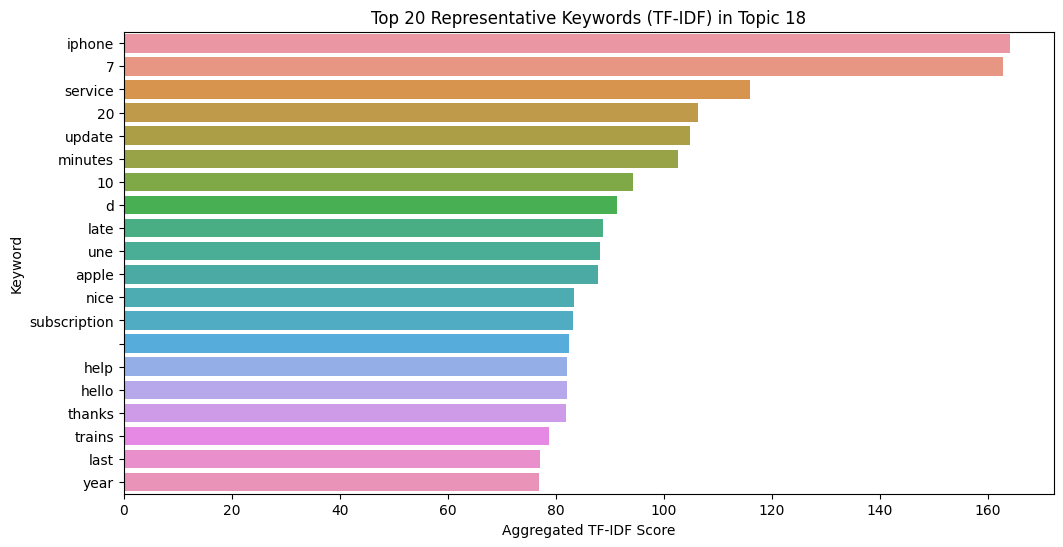

In [0]:
from pyspark.ml.clustering import LocalLDAModel
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the LDA model and sampled TF-IDF data
lda_model = LocalLDAModel.load("/dbfs/FileStore/twitter_customer_support/lda_model")
sampled_tfidf_df = spark.read.format("delta").load("/dbfs/FileStore/twitter_customer_support/sampled_tfidf_df")

# Infer topic distributions and identify dominant topics
get_dominant_topic_udf = udf(lambda x: int(np.argmax(x)), IntegerType())
topic_assignments = lda_model.transform(sampled_tfidf_df)\
    .withColumn("dominant_topic", get_dominant_topic_udf(col("topicDistribution")))

# Filter tweets for Topic 18
topic_num = 18
topic_tweets = topic_assignments.filter(col("dominant_topic") == topic_num)\
    .select("tweet_id", "text", "text_clean", "features")

# Convert to pandas for further analysis
pd_analysis_df = topic_tweets.select("tweet_id", "text_clean", "features").toPandas()

# Load vocabulary (mapping feature indices to words)
vocab_df = spark.read.format("delta").load("/dbfs/FileStore/twitter_customer_support/vocabulary")
vocab_list = vocab_df.orderBy("index").select("word").rdd.flatMap(lambda x: x).collect()

# Sum TF-IDF vectors across all tweets to identify top representative words
feature_vectors = pd_analysis_df['features'].tolist()

# Aggregate TF-IDF scores
sum_tfidf = np.sum([vec.toArray() for vec in feature_vectors], axis=0)

# Create dataframe of words with their TF-IDF scores
tfidf_scores_df = pd.DataFrame({
    'word': vocab_list,
    'tfidf_score': sum_tfidf
}).sort_values(by='tfidf_score', ascending=False).head(20)

# Visualization of Top TF-IDF Keywords
plt.figure(figsize=(12,6))
sns.barplot(x='tfidf_score', y='word', data=tfidf_scores_df)
plt.title(f'Top 20 Representative Keywords (TF-IDF) in Topic {topic_num}')
plt.xlabel('Aggregated TF-IDF Score')
plt.ylabel('Keyword')
plt.show()


### Dominant Topic Extraction and Top Representative Tweets for Topic 18

This cell performs the following steps:

1. **Load Data and Model:**
   - The sampled TF-IDF DataFrame is loaded from DBFS.
   - The LDA model is loaded from DBFS using `LocalLDAModel.load()`.

2. **Transform Data:**
   - The LDA model is applied to the sampled data to compute the topic distribution for each tweet.

3. **Extract Dominant Topic and Its Probability:**
   - Two UDFs are defined:
     - `get_dominant_topic` extracts the index of the highest probability from the topic distribution vector.
     - `get_dominant_topic_prob` extracts the highest probability (i.e., the strength of the dominant topic).
   - These UDFs are applied to add two new columns: `dominant_topic` and `topic_prob`.

4. **Filter and Sort Tweets for Topic 18:**
   - Tweets with `dominant_topic` equal to 18 are filtered.
   - The filtered tweets are sorted by the dominant topic probability in descending order, highlighting the most representative tweets.

5. **Prepare Data for LLM:**
   - The top 20 most representative tweets for Topic 18 are displayed.
   - The tweet texts are collected into a list for subsequent use (e.g., sending to an LLM for further analysis).


In [0]:
# Load the sampled data
sampled_tfidf_df = spark.read.format("delta").load("/dbfs/FileStore/twitter_customer_support/sampled_tfidf_df")

# Load the LDA model
from pyspark.ml.clustering import LDAModel
lda_model = LocalLDAModel.load("/dbfs/FileStore/twitter_customer_support/lda_model")

# Transform the data with the LDA model to get topic distributions
topic_dists = lda_model.transform(sampled_tfidf_df)

# Define a UDF to extract the dominant topic
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import numpy as np

# UDF to find the dominant topic and its probability
@udf("int")
def get_dominant_topic(topic_distribution):
    # Convert the vector to an array of floats
    topics = [float(x) for x in topic_distribution]
    # Return the index of the maximum value
    return int(np.argmax(topics))

@udf("double")
def get_dominant_topic_prob(topic_distribution):
    # Convert the vector to an array of floats
    topics = [float(x) for x in topic_distribution]
    # Return the maximum probability
    return float(np.max(topics))

# Extract the dominant topic and its probability
topic_assignments = topic_dists.withColumn(
    "dominant_topic", 
    get_dominant_topic(topic_dists["topicDistribution"])
).withColumn(
    "topic_prob",
    get_dominant_topic_prob(topic_dists["topicDistribution"])
)

# Check if we can see the columns
topic_assignments.printSchema()

# Filter for Topic 18 
topic_num = 18
topic_tweets = topic_assignments.filter(f"dominant_topic = {topic_num}")

# Select relevant columns and sort by probability
representative_tweets = topic_tweets.select(
    "tweet_id", "text", "topic_prob"
).orderBy("topic_prob", ascending=False)

# Show the top 20 most representative tweets
top_tweets = representative_tweets.limit(20)
display(top_tweets)

# Convert to a list for sending to LLM
top_tweets_list = [row.text for row in top_tweets.collect()]

tweet_id text topic_prob 74703 @AmazonHelp Déja quand je leur pose une simple question ils me disent qu'il leur faut 5 jours pour pouvoir me répondre alors leur demander une étiquette de retour ça risque de prendre 7 jours mdr 0.9951468850950713 676425 @AmericanAir @116462 On a separate issue, on the flight down I paid for WiFi. It was so slow that it couldn’t run gmail (except in HTML mode). I get that international internet is hard and likely slow, but a warning it largely is nonfunctional for common uses would have been nice. 0.9928376990665857 2400350 @115850 Order no 171-2862611-2263524 ! Your customer care people are liar & inspite of ordering goods worth 20 lac dis year mistreated 0.9889007837536842 2839951 So nice to see how friendly staff at @marksandspencer Baker Street are. Taking extra time to help a blind/partially sighted person choose their dinner! #allthefeels 0.9883937864724653 2825315 Just trying to be nice and converse with my @115879 driver but then he has to comment on my profile photo and how much he likes it 🙃 sir it is 4 am, ty for making me uncomfortable. 0.9880620849203345 1623302 @O2 Yes. I have the 20GB as per my refresh contract but every time it gets near 2GB I get this warning. It is just annoying. 0.988049455020717 2713829 @115955 your service is ruining my shows. My service keeps freezing and skipping. Seriously considering changing service you’re simply not worth it 0.987803769324412 627620 @LondonMidland My trains so far this week have been delayed by 29 minutes (over 5 trains), and my trains this month have been delayed by 2 hours 32 minutes. 0.9876698102501597 1768112 @AppleSupport Both, iPhone 7 Plus, iPhone 8, Mac/PC No Difference. Tried Multiple ISPs. Unable To Verify 0.987336968735809 1975087 Booked an airbnb stay for Tokyo weeks ago and was just sent house rules for when I arrive in a week ... which states: https://t.co/GCYEdpiVdc 0.987003208998109 1568545 @GWRHelp will rail replacement be running now that the 20:49 Bristol Temple Meads to Weymouth service is cancelled? 0.9868253488979731 229704 @DellCares Facing problem with DELL Power edgeR630. Windows in not loading up after changing the faulty Hard disc in RAID 5. 0.9862599561446745 2393485 @AmazonHelp Bonjour plusieurs commandes sont retardés.. Livraison prime inutile désormais ? 0.9843348764718495 1714686 @AskeBay I figured that out. That doesn’t make calling your product apple when its not an acceptable practice. 0.9797896851959234 2916995 Why is ordering a @118197 computer so hard? Money in hand, order cancelled 3x! @DellCares 0.9794360933957952 68024 @Morrisons Hiya do you stock sun in hair lightening spray? Thank you 😊 0.9785619884804823 2346733 Nice surprise from SEA to RDU! Thanks @Delta for the complimentary #flightfuel https://t.co/C8Vb44qjKG 0.9765525590309722 281592 @115911 @14250 @183094 Maybe improve your customer service skills drastically. 0.9751663299128746 388380 @AmazonHelp Separete shipments, also received in separate shipments. 
 0.9727342378346662 1291264 Hello @Safaricom_Care I repaid my Mshwari but I have been denied the service again . Plz help 0.9721738768749372

### Analyzing Tweets with the LLM API

In this cell, we perform the following steps:

1. **Construct the Prompt:**  
   - We join the text of the top 20 representative tweets (previously collected in `top_tweets_list`) into a numbered list.
   - A prompt is constructed that instructs the LLM to provide a concise summary of the main customer issues and complaints related to iPhone problems and service based on these tweets.

2. **Define the API Call Function:**  
   - The `analyze_tweets` function sends an HTTP POST request to the LLM API endpoint using the provided prompt.
   - The function includes error handling and prints debugging information (e.g., request payload structure, response status, and structure).
   - If the API call is successful, the function extracts and returns the summary from the response.

3. **Call the API and Display Results:**  
   - The API is called with the constructed prompt, and the resulting summary is stored in `tweet_summary`.
   - The summary is printed to the console and displayed using IPython’s Markdown display for better readability.


In [0]:
import requests
import time

# Define the API endpoint
api_endpoint = "your_endpoint_url"

# Create a prompt for the LLM to analyze the tweets
tweets_text = "\n".join([f"{i+1}. {tweet}" for i, tweet in enumerate(top_tweets_list)])

prompt = f"""
These are the 20 most representative customer support tweets related to iPhone problems and service:

{tweets_text}

Please provide a concise summary of the main customer issues and complaints found in these tweets.
"""

# Function to call the LLM API with better error handling and debugging
def analyze_tweets(prompt, api_endpoint, api_key):
    print("Sending request to LLM API...")
    
    try:
        headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }
        
        payload = {
            "messages": [
                {"role": "system", "content": "You are an expert in customer service analysis."},
                {"role": "user", "content": prompt}
            ],
            "model": "databricks-meta-llama-3-3-70b-instruct",
            "max_tokens": 500
        }
        
        # Print the structure of our request (without the auth token)
        print(f"Request endpoint: {api_endpoint}")
        print(f"Request payload structure: {list(payload.keys())}")
        
        # Send the request
        response = requests.post(api_endpoint, headers=headers, json=payload)
        
        # Print response status
        print(f"Response status code: {response.status_code}")
        
        if response.status_code == 200:
            # Parse the response
            result = response.json()
            print("Successfully received response")
            
            # Debug the response structure
            print(f"Response structure: {list(result.keys())}")
            
            # Extract content based on the response structure
            if "choices" in result and len(result["choices"]) > 0:
                if "message" in result["choices"][0]:
                    content = result["choices"][0]["message"]["content"]
                    return content
                else:
                    print(f"Unexpected response structure: {result}")
                    return "Error: Unexpected response structure"
            else:
                print(f"Unexpected response structure: {result}")
                return "Error: Unexpected response structure"
        else:
            error_msg = f"API error: {response.status_code} - {response.text}"
            print(error_msg)
            return error_msg
    
    except Exception as e:
        error_msg = f"Exception: {str(e)}"
        print(error_msg)
        return error_msg

# Call the API to analyze the tweets
print("Starting tweet analysis...")
tweet_summary = analyze_tweets(prompt, api_endpoint, api_key)

# Display the summary
print("\n\n## Summary of Main Customer Issues in Topic 18:")
print(tweet_summary)

# If using a notebook, also use display to show the results
from IPython.display import Markdown
display(Markdown("## Summary of Main Customer Issues in Topic 18:"))
display(Markdown(tweet_summary))

## Summary of Main Customer Issues in Topic 18:

After analyzing the 20 customer support tweets, I identified the following main customer issues and complaints:

1. **Delayed or unresponsive customer support**: Several customers expressed frustration with slow or unresponsive customer support, including long wait times for responses (tweets 1, 3, 18).
2. **Technical issues with products or services**: Customers reported problems with iPhone functionality (tweet 9), internet connectivity (tweet 2), and computer hardware issues (tweets 12, 15).
3. **Order and delivery problems**: Issues with order cancellations (tweet 15), delayed shipments (tweets 1, 13, 19), and missing items (tweet 3) were reported.
4. **Poor customer service interactions**: Customers complained about uncomfortable interactions with customer support representatives (tweet 5), rude or unhelpful staff (tweets 3, 18), and lack of assistance with special needs (tweet 4).
5. **Service disruptions and cancellations**: Customers experienced frustration with delayed or cancelled trains (tweets 8, 11), interrupted TV services (tweet 7), and denied access to services (tweet 20).
6. **Product misrepresentation**: One customer felt misled by a product's name, which didn't match the actual product (tweet 14).

These categories represent the main themes of customer complaints and issues found in the analyzed tweets.